In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import sqrtm

In [2]:
N_TRIAL = 30000
N_ARMS = 100
N_FEATURE = 3
M = 4
np.random.seed(123)

In [3]:
Beta = np.genfromtxt('Beta.csv',delimiter=',')
X_1 = np.genfromtxt('X.csv',delimiter=',')
Y_1 = np.genfromtxt('Y.csv',delimiter=',')
E = np.genfromtxt('E.csv',delimiter=',')
# W = np.genfromtxt('W.csv',delimiter=',')
# E2 = np.genfromtxt('E(100).csv',delimiter=',')

In [4]:
lda = 50
F = np.identity(n=N_ARMS) + lda * E
F_kron = np.kron(F, np.identity(n=N_FEATURE))
FInv_Init = sqrtm(np.linalg.inv(np.kron(F, np.identity(n=N_FEATURE))))
# F_sqrt = sqrtm(np.kron(F, np.identity(n=N_FEATURE)))

In [5]:
# convert to a sparse matrix -> convert to a long sparse vector with flatten()
def X_to_X_m(X, t, arm_choice, n_arms, n_feature): 
  X_m = np.copy(X[t])
  for arm in np.arange(n_arms): # N x p
    if arm not in arm_choice:
      X_m[arm] = np.zeros(shape=n_feature)
  return X_m

In [ ]:
def plot_regrets(results, oracle):
    [plt.plot(make_regret(payoff=x['r_payoff'], oracle=oracle), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]

def make_regret(payoff, oracle):
    return np.cumsum(oracle - payoff)

In [7]:
def plot_l2_norm_diff(results, true_theta, n_trial, n_arms, n_feature, FInv_Init):
    [plt.plot(make_l2_norm_diff(x['theta_lst'], true_theta, n_trial, n_arms, n_feature, FInv_Init), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]
def make_l2_norm_diff(theta, true_theta, n_trial, n_arms, n_feature, FInv_Init):
    diff = []
    for t in range(n_trial):
        theta_matrix = (FInv_Init.dot(theta[t])).reshape(n_arms, n_feature) #with FInv_Init
#         theta_matrix = theta[t].reshape(n_arms, n_feature) #without FInv_Init
        diff_t = 0
        for arm in range(n_arms):
            diff_vec = theta_matrix[arm] - true_theta[arm]
            diff_t += np.linalg.norm(diff_vec, ord=2)
        diff.append(diff_t)
        # show the difference every 3000 iterations
        if (t+1) % 3000 == 0:
            print('TRIAL:', t+1 , 'diff:', diff_t)
    return np.array(diff)

In [8]:
def GOBLin(alpha, eta, lda, X, Y, m, E):
    print("GOB.Lin with alpha: ", alpha)
    n_trial, n_arms, n_feature = X.shape
    
    # 1.1.output object
    r_payoff = np.empty(n_trial)
    arm_choice = np.empty(shape=(n_trial, m), dtype=int)
    p = np.empty(shape=(n_trial, n_arms))
    
    F = np.identity(n=n_arms) + lda * E
    F_kron = np.kron(F, np.identity(n=n_feature))
    FInv = sqrtm(np.linalg.inv(np.kron(F, np.identity(n=n_feature))))
    F_sqrt = sqrtm(np.kron(F, np.identity(n=n_feature)))
    # 1.2. A and b

    A = eta * np.identity(n = n_feature * n_arms)   #dn x dn
    b = np.zeros(shape=n_feature * n_arms)        #dn x 1
    inv_A = np.linalg.inv(A)
    theta_lst = np.empty(shape=(n_trial, n_arms *  n_feature))
    theta = np.dot(inv_A, b)
    
    # 2. Algorithm
      # theta = w
      # A = M
      # b = b
      # p_t = k_t
    for t in np.arange(n_trial):
        
        #Compute estimates (theta) and prediction (p) for all arms
        for a in np.arange(n_arms):
            X_1_tr = FInv.dot((X_to_X_m(X, t, [a], n_arms, n_feature)).flatten())
            p[t, a] = theta.dot(X_1_tr) + alpha * np.sqrt(np.dot(np.dot(X_1_tr, inv_A), X_1_tr)) #.clip(0))
            
        # Choose m best arms
        idx = np.argpartition(p[t], -m)[-m:]
        chosen_arms = idx[np.argsort((-p[t])[idx])]
        for i in np.arange(m):
          arm_choice[t][i] = chosen_arms[i]
        
        #update A and b
        for chosen_arm in arm_choice[t]:
          X_1_tr_chosen = FInv.dot((X_to_X_m(X_1, t, [chosen_arm], n_arms, n_feature)).flatten())
          A = A + np.outer(X_1_tr_chosen, X_1_tr_chosen)
          b = b + Y[t, chosen_arm] * X_1_tr_chosen
        inv_A = np.linalg.inv(A)
        theta = inv_A.dot(b)
        theta_lst[t] = theta
        r_payoff[t]   = np.sum([Y[t, choice] for choice in arm_choice[t]])
        
        # show the selected arms every 3000 iterations
        if t % 3000 == 0:
            print('TRIAL:',t,'DONE', '| arm selected:', chosen_arms)
    return dict(theta=theta, theta_lst=theta_lst, p=p, arm_choice = arm_choice, r_payoff=r_payoff, A=A)

In [9]:
# create X
X_1_lst = []
for T in np.arange(N_TRIAL):
  X_1t_lst = []
  for arm in np.arange(N_ARMS):
    temp = []
    temp.append(1)
    temp.append(0.001*(T+1))
    temp.append((0.001*(T+1))**2)
    X_1t_lst.append(np.array(temp))
    # np.append(X_1, X_1t)
  X_1_lst.append(np.array(X_1t_lst))
X_1 = np.array(X_1_lst)

In [10]:
# True Beta
Beta_reshape = Beta.T
Beta_reshape.shape

(100, 3)

In [11]:
# True M highest rewards  
oracle_lst = []
for t in np.arange(N_TRIAL):
  # Find indices of M highest arms
  all_reward_t = [Y_1.T[t, arm] for arm in np.arange(N_ARMS)]
  idx = np.argpartition(all_reward_t, -M)[-M:]
  chosen_arms = idx[np.argsort((-np.array(all_reward_t))[idx])]
  # Sum of M highest rewards
  oracle_payoff_t = np.sum([Y_1.T[t, choice] for choice in chosen_arms])
  # Append to the list
  oracle_lst.append(oracle_payoff_t)
#   print(chosen_arms)
oracle_case1 = np.array(oracle_lst)

In [12]:
# Run GOB.Lin
alpha_to_test = [0, 1, 2.5, 5, 10, 20]
# alpha_to_test = [0, 1, 2.5, 5, 10, 20]
results_dict = {alpha: GOBLin(alpha = alpha, eta = 0.3, lda = 50, X=X_1, Y=Y_1.T, m=M, E=E)\
                for alpha in alpha_to_test}

GOB.Lin with alpha:  0


C:\Users\ARTY\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\ARTY\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: ComplexWarning: Casting complex values to real discards the imaginary part


TRIAL: 0 DONE | arm selected: [33 35 32 99]
TRIAL: 500 DONE | arm selected: [99 35 88 44]
TRIAL: 1000 DONE | arm selected: [99 88 35 44]
TRIAL: 1500 DONE | arm selected: [99 88 35 44]
TRIAL: 2000 DONE | arm selected: [99 88 35 44]
TRIAL: 2500 DONE | arm selected: [99 88 35 44]
TRIAL: 3000 DONE | arm selected: [99 88 35 44]
TRIAL: 3500 DONE | arm selected: [99 88 35 44]
TRIAL: 4000 DONE | arm selected: [99 88 35 44]
TRIAL: 4500 DONE | arm selected: [99 88 35 44]
TRIAL: 5000 DONE | arm selected: [99 88 35 44]
TRIAL: 5500 DONE | arm selected: [99 88 35 44]
TRIAL: 6000 DONE | arm selected: [99 88 35 44]
TRIAL: 6500 DONE | arm selected: [99 88 35 44]
TRIAL: 7000 DONE | arm selected: [99 88 35 44]
TRIAL: 7500 DONE | arm selected: [99 88 35 44]
TRIAL: 8000 DONE | arm selected: [99 88 35 44]
TRIAL: 8500 DONE | arm selected: [99 88 35 44]
TRIAL: 9000 DONE | arm selected: [99 88 35 44]
TRIAL: 9500 DONE | arm selected: [99 88 35 44]
TRIAL: 10000 DONE | arm selected: [99 88 35 44]
TRIAL: 10500 DON

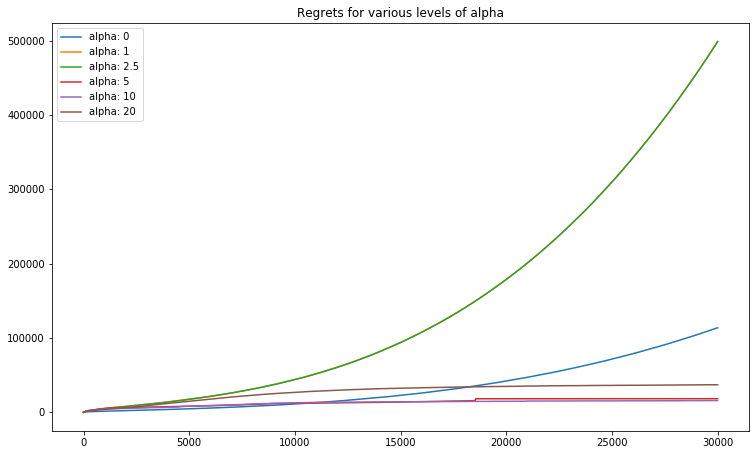

In [13]:
# Plot regrets
plt.figure(figsize=(12.5, 7.5))
plot_regrets(results_dict, oracle_case1)
# plt.plot(make_regret(payoff=payoff_random, oracle=oracle_case1), label = "random", linestyle='--')
plt.legend()
plt.title("Regrets for various levels of alpha")
plt.show()

In [14]:
dict2 = results_dict.copy()
dict2.pop(0)
dict2.pop(1)
# dict2

{'theta': array([ 1.44462778e+01-1.56136800e-16j, -9.59595438e-01-2.53660391e-16j,
        -7.42823834e-01-6.49572182e-17j,  1.49326618e+01+5.11191977e-18j,
        -9.99973118e-02+3.59200838e-17j, -9.00115927e-02+1.49594133e-17j,
         1.45419009e+01-2.61198336e-16j, -1.29049098e-01+4.62755864e-16j,
        -1.52047705e-01-1.50291348e-16j,  1.51871876e+01+1.61813288e-16j,
        -4.30860068e-01-8.73635574e-17j, -4.53483597e-01+5.75781831e-17j,
         1.49178910e+01+4.84069610e-18j, -1.01465203e-01+2.00377326e-18j,
        -9.20406717e-02-3.12703155e-17j,  1.49526405e+01+4.53936660e-18j,
        -1.01935738e-01+3.51500755e-18j, -9.31342887e-02+6.50899054e-19j,
         1.49078965e+01+4.57615411e-18j, -1.00769907e-01+1.80235723e-17j,
        -9.04045778e-02-1.20948567e-19j,  1.49227702e+01+1.66475030e-17j,
        -1.01797124e-01-3.29163003e-18j, -9.17998466e-02+1.15441350e-17j,
         1.51491409e+01+4.52344457e-18j, -8.24593871e-02+3.22274324e-18j,
        -8.15070102e-02-1.503

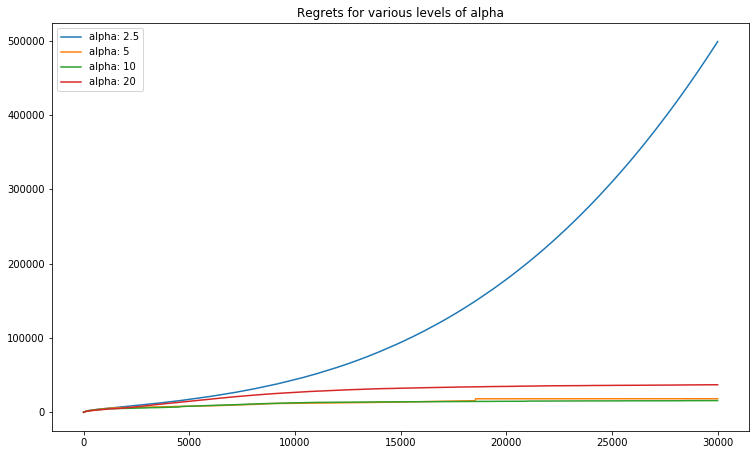

In [15]:
plt.figure(figsize=(12.5, 7.5))
plot_regrets(dict2, oracle_case1)
# plt.plot(make_regret(payoff=payoff_random, oracle=oracle_case1), label = "random", linestyle='--')
plt.legend()
plt.title("Regrets for various levels of alpha")
plt.show()

In [16]:
dict3 = dict2.copy()
dict3.pop(2.5)

{'theta': array([ 1.44654272e+01-7.74494381e-15j, -7.75658618e-01+2.43076444e-16j,
        -3.17807274e-01+5.92242458e-17j,  1.48986495e+01+1.35342913e-17j,
        -2.35098906e-01+9.52090380e-17j, -5.10874315e-01+1.39802266e-17j,
         1.34211775e+01+7.26309790e-15j, -1.40672936e+00-1.07673306e-16j,
        -1.39538480e+00-1.40659678e-16j,  1.50939382e+01+1.27296368e-16j,
        -4.43669589e-01-9.36020745e-17j, -2.42108295e-01-6.97272230e-18j,
         1.48826004e+01+4.97378801e-18j, -2.42377307e-01+2.55235140e-18j,
        -5.30160238e-01+3.97036374e-18j,  1.49196987e+01+4.87968536e-18j,
        -2.34938547e-01+3.69047228e-18j, -5.03576003e-01+2.35682473e-19j,
         1.48720581e+01+4.45661972e-18j, -2.43130834e-01+1.85948919e-17j,
        -5.35620507e-01-5.46852423e-19j,  1.48877510e+01+1.56580389e-17j,
        -2.41981839e-01-3.31407377e-18j, -5.28508340e-01-1.87040879e-17j,
         1.51444118e+01+5.07600340e-18j, -1.03852903e-01+3.38554440e-18j,
        -1.09958285e-01+7.486

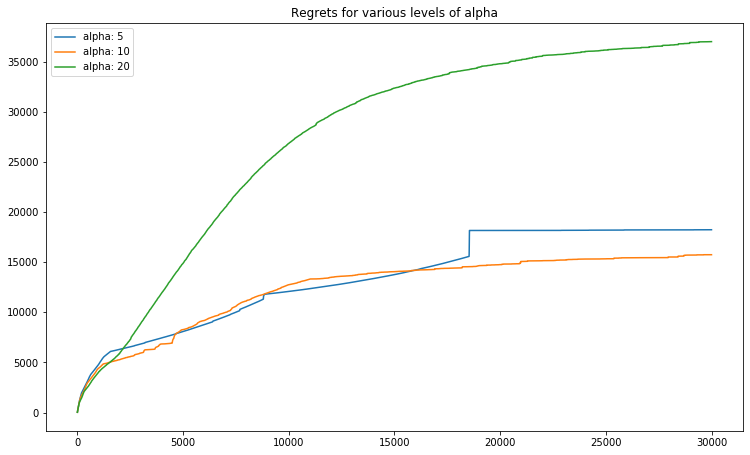

In [17]:
plt.figure(figsize=(12.5, 7.5))
plot_regrets(dict3, oracle_case1)
# plt.plot(make_regret(payoff=payoff_random, oracle=oracle_case1), label = "random", linestyle='--')
plt.legend()
plt.title("Regrets for various levels of alpha")
plt.show()

In [18]:
# Plot l2-difference
#True Beta
Beta_reshape = Beta.T
Beta_reshape.shape
# t_l2_norm_lst = []
# for i in range (N_ARMS):
#     t_l2_norm_lst.append(np.linalg.norm(Beta_reshape[i], ord=2))
# t_l2_norm = np.array(t_l2_norm_lst)

TRIAL: 1000 diff: 627.5674063279954
TRIAL: 2000 diff: 588.8827956780087
TRIAL: 3000 diff: 554.7119698962362
TRIAL: 4000 diff: 548.2720761791624
TRIAL: 5000 diff: 548.4857763922408
TRIAL: 6000 diff: 550.1247537708123
TRIAL: 7000 diff: 551.9507163961692
TRIAL: 8000 diff: 553.6012012468449
TRIAL: 9000 diff: 555.0602333412888
TRIAL: 10000 diff: 556.3439541292306
TRIAL: 11000 diff: 557.4566241363161
TRIAL: 12000 diff: 558.4134825402236
TRIAL: 13000 diff: 559.1985474582224
TRIAL: 14000 diff: 559.9053020728552
TRIAL: 15000 diff: 560.5059986550201
TRIAL: 16000 diff: 561.0341123019757
TRIAL: 17000 diff: 561.5184881316982
TRIAL: 18000 diff: 561.9745278588405
TRIAL: 19000 diff: 562.342857804655
TRIAL: 20000 diff: 562.6937762022313
TRIAL: 21000 diff: 562.9886637536817
TRIAL: 22000 diff: 563.2691572407547
TRIAL: 23000 diff: 563.5338228336637
TRIAL: 24000 diff: 563.7712173506259
TRIAL: 25000 diff: 563.9960643597686
TRIAL: 26000 diff: 564.2180808926013
TRIAL: 27000 diff: 564.4280067808106
TRIAL: 2800

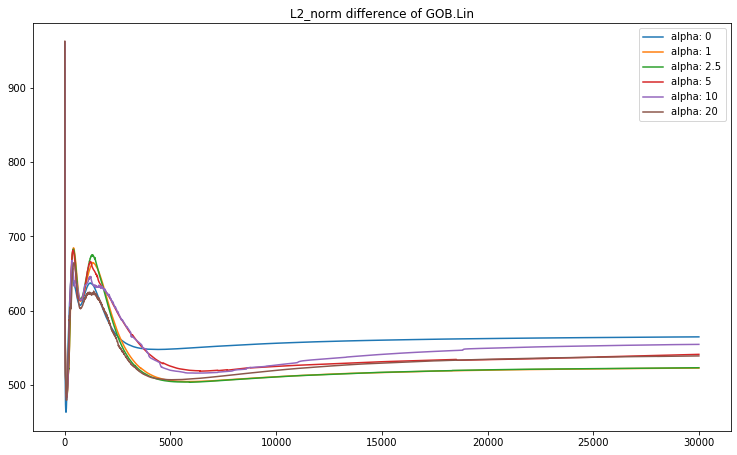

In [19]:
# Plot l2_norm difference for various levels of alpha
plt.figure(figsize=(12.5, 7.5))
plot_l2_norm_diff(results_dict, Beta_reshape, n_trial=N_TRIAL, n_arms=N_ARMS, n_feature=N_FEATURE, FInv_Init=FInv_Init)
plt.legend()
plt.title("L2_norm difference of GOB.Lin")
plt.show()

TRIAL: 1000 diff: 639.1879462197064
TRIAL: 2000 diff: 623.2807812384054
TRIAL: 3000 diff: 574.2888421160277
TRIAL: 4000 diff: 541.5266216170947
TRIAL: 5000 diff: 525.5413030802227
TRIAL: 6000 diff: 519.7649395220936
TRIAL: 7000 diff: 519.5776745647571
TRIAL: 8000 diff: 521.1142112406413
TRIAL: 9000 diff: 523.5676148118636
TRIAL: 10000 diff: 525.2361264830402
TRIAL: 11000 diff: 526.7420192286291
TRIAL: 12000 diff: 528.1048194478883
TRIAL: 13000 diff: 529.3302173303914
TRIAL: 14000 diff: 530.4391132675192
TRIAL: 15000 diff: 531.5020839815878
TRIAL: 16000 diff: 532.4393734459596
TRIAL: 17000 diff: 533.2941652584783
TRIAL: 18000 diff: 534.1502699955695
TRIAL: 19000 diff: 533.7376284783139
TRIAL: 20000 diff: 534.2436758351862
TRIAL: 21000 diff: 534.8057625312674
TRIAL: 22000 diff: 535.3755023258599
TRIAL: 23000 diff: 536.2365472809834
TRIAL: 24000 diff: 536.9019905684609
TRIAL: 25000 diff: 537.5929366949687
TRIAL: 26000 diff: 538.4882038811213
TRIAL: 27000 diff: 539.2248636478524
TRIAL: 280

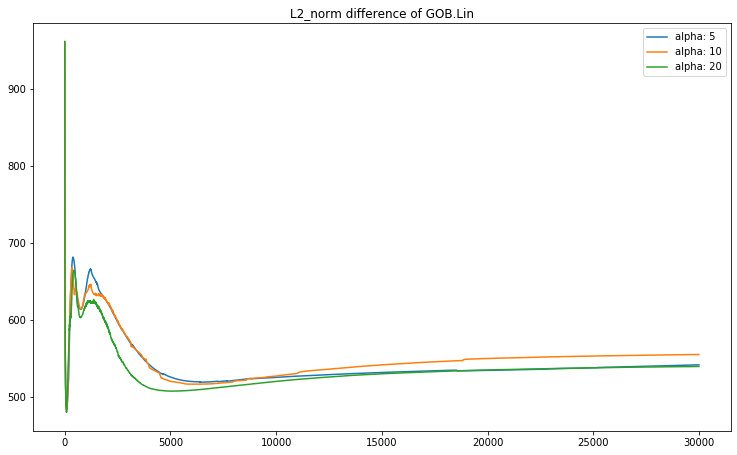

In [20]:
# Plot l2_norm difference for various levels of alpha
plt.figure(figsize=(12.5, 7.5))
plot_l2_norm_diff(dict3, Beta_reshape, n_trial=N_TRIAL, n_arms=N_ARMS, n_feature=N_FEATURE, FInv_Init=FInv_Init)
plt.legend()
plt.title("L2_norm difference of GOB.Lin")
plt.show()

In [21]:
# 0 = 0, 1 = 1, 2 = 2.5, 3 = 5, 4 = 10, 5 = 20
# export regret data
test_lst = [make_regret(payoff=x['r_payoff'], oracle=oracle_case1) for (alpha, x) in results_dict.items()]
df = pd.DataFrame(test_lst[4]) #index 
df.to_csv('GOBLin10lda10_regret.csv', header=False)

In [22]:
# export l2 data
test_lst2 = [make_l2_norm_diff(x['theta_lst'], Beta_reshape, N_TRIAL, N_ARMS, N_FEATURE, FInv_Init=FInv_Init) for (alpha, x) in results_dict.items()]
df2 = pd.DataFrame(test_lst2[4]) #index 
df2.to_csv('GOBLin10_l2norm.csv', header=False)

TRIAL: 1000 diff: 627.5674063279954
TRIAL: 2000 diff: 588.8827956780087
TRIAL: 3000 diff: 554.7119698962362
TRIAL: 4000 diff: 548.2720761791624
TRIAL: 5000 diff: 548.4857763922408
TRIAL: 6000 diff: 550.1247537708123
TRIAL: 7000 diff: 551.9507163961692
TRIAL: 8000 diff: 553.6012012468449
TRIAL: 9000 diff: 555.0602333412888
TRIAL: 10000 diff: 556.3439541292306
TRIAL: 11000 diff: 557.4566241363161
TRIAL: 12000 diff: 558.4134825402236
TRIAL: 13000 diff: 559.1985474582224
TRIAL: 14000 diff: 559.9053020728552
TRIAL: 15000 diff: 560.5059986550201
TRIAL: 16000 diff: 561.0341123019757
TRIAL: 17000 diff: 561.5184881316982
TRIAL: 18000 diff: 561.9745278588405
TRIAL: 19000 diff: 562.342857804655
TRIAL: 20000 diff: 562.6937762022313
TRIAL: 21000 diff: 562.9886637536817
TRIAL: 22000 diff: 563.2691572407547
TRIAL: 23000 diff: 563.5338228336637
TRIAL: 24000 diff: 563.7712173506259
TRIAL: 25000 diff: 563.9960643597686
TRIAL: 26000 diff: 564.2180808926013
TRIAL: 27000 diff: 564.4280067808106
TRIAL: 2800